## Preprocessing

In [ ]:
import os
spark_version = 'spark-3.5.0'
os.environ['SPARK_VERSION']=spark_version

In [ ]:
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 229 kB in 6s (38.8 kB/s)
Reading package lists... Done


In [ ]:
#Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

In [ ]:
# Start a SparkSession
import findspark
findspark.init()


In [ ]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from pyspark.sql import SparkSession
import time



#  Import and read the diabetes_prediction_dataset.csv.
import pandas as pd
url = "https://raw.githubusercontent.com/taywiljoe/Project-4/main/diabetes_prediction_dataset.csv"
diabetes_df = pd.read_csv(url)
diabetes_df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [ ]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
#application_df.drop(['EIN', 'NAME'], axis=1, inplace=True)
#application_df



In [ ]:
# Determine the number of unique values in each column.
diabetes_df.nunique()

gender                    3
age                     102
hypertension              2
heart_disease             2
smoking_history           6
bmi                    4247
HbA1c_level              18
blood_glucose_level      18
diabetes                  2
dtype: int64

In [ ]:
diabetes_df['diabetes'].value_counts()

0    91500
1     8500
Name: diabetes, dtype: int64

In [ ]:
recall

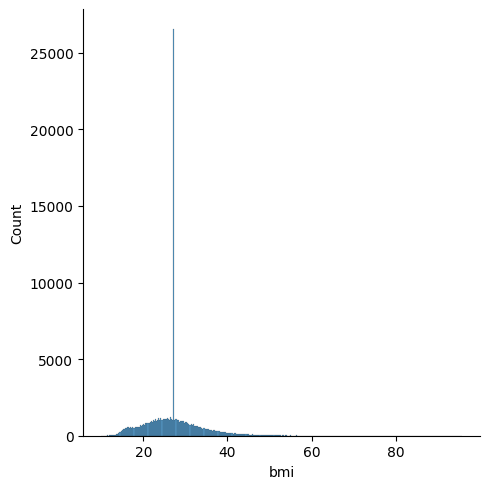

In [ ]:
import seaborn as sns
sns.displot(diabetes_df['bmi'])

In [ ]:
# Look at bmi value counts for binning
diabetes_df['bmi'].value_counts()


27.32    25495
23.00      103
27.12      101
27.80      100
24.96      100
         ...  
58.23        1
48.18        1
55.57        1
57.07        1
60.52        1
Name: bmi, Length: 4247, dtype: int64

In [ ]:
# You may find it helpful to look at CLASSIFICATION value counts >1
#application_df['CLASSIFICATION'].value_counts().gt(1).sum()
diabetes_df['bmi'].value_counts().loc[lambda x : x<35]


29.48    34
19.73    34
30.99    34
34.13    34
19.50    34
         ..
58.23     1
48.18     1
55.57     1
57.07     1
60.52     1
Name: bmi, Length: 3573, dtype: int64

In [ ]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`
#df1['binned'] = pd.cut(df1['Score'], bins,labels=labels)
#print (df1)
#bmi_types_to_replace = [58.23,48.18,55.57,57.07,60.52]

# Replace in dataframe
#for app in bmi_types_to_replace:
#    diabetes_df['bmi'] = application_df['bmi'].replace(app,"Other")

# Check to make sure binning was successful
#diabetes_df['bmi'].value_counts()

In [ ]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace'
#classifications_to_replace = ['C4120','C8210','C2561','C4500','C2150','C1235',
#'C2150']

# Replace in dataframe
#for cls in classifications_to_replace:
#   diabetes_df['CLASSIFICATION'] = diabetes_df['CLASSIFICATION'].replace(cls,"Other")

# Check to make sure binning was successful
#diabetes_df['CLASSIFICATION'].value_counts()

In [ ]:
# Convert categorical data to numeric with `pd.get_dummies`
y = diabetes_df['diabetes']
X = diabetes_df.drop(columns='diabetes')
X = pd.get_dummies(X)
X.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,1,0,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,1,0,0,1,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,1,0,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,1,0,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,1,0,0,1,0,0,0,0


In [ ]:
# Import the RandomOverSampler module from imbalanced-learn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
ros = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_res, y_res = ros.fit_resample(X, y)
# Count the distinct values of the resampled labels data
print('Resampled dataset shape %s' % Counter(y_res))


Resampled dataset shape Counter({0: 91500, 1: 91500})


In [ ]:
# Split our preprocessed data into our features and target arrays
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=1)
X_train.shape

# Split the preprocessed data into a training and testing dataset
#  YOUR CODE GOES HERE

(137250, 15)

In [ ]:
X_test.shape


(45750, 15)

In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled

array([[-1.79168244, -0.42468913, -0.31414261, ..., -0.39535497,
        -0.76607461, -0.2801949 ],
       [ 1.36876559, -0.42468913,  3.18326762, ..., -0.39535497,
        -0.76607461, -0.2801949 ],
       [-0.44384431,  2.3546635 , -0.31414261, ..., -0.39535497,
         1.30535588, -0.2801949 ],
       ...,
       [-0.6762302 , -0.42468913, -0.31414261, ..., -0.39535497,
         1.30535588, -0.2801949 ],
       [ 1.36876559,  2.3546635 , -0.31414261, ...,  2.52937254,
        -0.76607461, -0.2801949 ],
       [ 1.22933405, -0.42468913, -0.31414261, ..., -0.39535497,
        -0.76607461, -0.2801949 ]])

In [ ]:
X_test_scaled

array([[ 0.06740463, -0.42468913,  3.18326762, ..., -0.39535497,
        -0.76607461, -0.2801949 ],
       [ 0.16035899, -0.42468913, -0.31414261, ..., -0.39535497,
        -0.76607461, -0.2801949 ],
       [-1.32691067, -0.42468913, -0.31414261, ..., -0.39535497,
         1.30535588, -0.2801949 ],
       ...,
       [ 1.22933405, -0.42468913, -0.31414261, ..., -0.39535497,
         1.30535588, -0.2801949 ],
       [-0.53679867, -0.42468913, -0.31414261, ..., -0.39535497,
        -0.76607461,  3.56894433],
       [-1.83815962, -0.42468913, -0.31414261, ..., -0.39535497,
        -0.76607461, -0.2801949 ]])

## Compile, Train and Evaluate the Model

In [ ]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn_model = tf.keras.models.Sequential()

# First hidden layer
nn_model.add(tf.keras.layers.Dense(units=5, activation="relu", input_dim=15))

# Second hidden layer
nn_model.add(tf.keras.layers.Dense(units=3, activation="relu"))

# Output layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 80        
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 102 (408.00 Byte)
Trainable params: 102 (408.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
4290/4290 [==============================] - 14s 3ms/step - loss: 0.2157 - accuracy: 0.8968
Epoch 2/100
4290/4290 [==============================] - 9s 2ms/step - loss: 0.2154 - accuracy: 0.8974
Epoch 3/100
4290/4290 [==============================] - 9s 2ms/step - loss: 0.2153 - accuracy: 0.8971
Epoch 4/100
4290/4290 [==============================] - 8s 2ms/step - loss: 0.2156 - accuracy: 0.8972
Epoch 5/100
4290/4290 [==============================] - 9s 2ms/step - loss: 0.2153 - accuracy: 0.8969
Epoch 6/100
4290/4290 [==============================] - 8s 2ms/step - loss: 0.2155 - accuracy: 0.8976
Epoch 7/100
4290/4290 [==============================] - 8s 2ms/step - loss: 0.2153 - accuracy: 0.8972
Epoch 8/100
4290/4290 [==============================] - 9s 2ms/step - loss: 0.2153 - accuracy: 0.8973
Epoch 9/100
4290/4290 [==============================] - 8s 2ms/step - loss: 0.2155 - accuracy: 0.8970
Epoch 10/100
4290/4290 [==============================] - 9s 2ms/step - 

In [ ]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1430/1430 - 2s - loss: 0.2152 - accuracy: 0.8967 - 2s/epoch - 1ms/step
Loss: 0.21520914137363434, Accuracy: 0.8967213034629822


In [ ]:
# Export our model to HDF5 file
#  YOUR CODE GOES HERE